# 1. Install packages

In [71]:
!pip install tensorflow opencv-python matplotlib albumentations 


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 2. Import our packages and build image loading function

In [72]:
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import numpy as np

In [73]:
def load_image_resize(image):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img, [400, 400])
    return img

def load_image_no_resize(image):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img)
    return img

In [74]:
images = tf.data.Dataset.list_files('data\\training\\images\\*.jpg', shuffle=True).map(load_image_resize)

## Plot some training samples

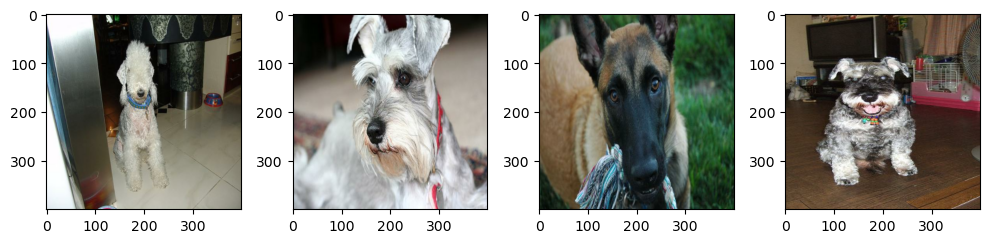

In [75]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
plot_images = plot_images / 255.0

fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for id, img in enumerate(plot_images):
    ax[id].imshow(img)
fig.tight_layout()
plt.show()

# 3. Crete augmentation pipline

In [76]:
import albumentations as A
import os
import cv2

In [77]:
IMAGE_SIZE = 224

augmentor = A.Compose(
    [A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.2),
    A.RGBShift(p=0.2),
    A.VerticalFlip(p=0.5)],
    bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels'])
)

In [78]:
GENERARTE_AUGMENTED_IMAGES = False
AUGMENTATIONS_PER_IMAGE = 30
if GENERARTE_AUGMENTED_IMAGES:
    for partition in ['training', 'validation', 'test']:
        for image in os.listdir(os.path.join('data', partition, 'images')):
            img = cv2.imread(os.path.join('data', partition, 'images', image))
            object_cords = [0, 0, 0.00001, 0.00001]
            label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
            # check if label json exists 
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label = json.load(f)
                # extract and normalize bbox coordinates
                object_cords[0] = label['shapes'][0]['points'][0][0]
                object_cords[1] = label['shapes'][0]['points'][0][1]
                object_cords[2] = label['shapes'][0]['points'][1][0]
                object_cords[3] = label['shapes'][0]['points'][1][1]
                
                img_h = img.shape[0]
                img_w = img.shape[1]
            
                object_cords = list(np.divide(
                    object_cords,
                    [img_w, img_h, img_w, img_h]
                ))
            
            # augment every image AUGMENTATIONS_PER_IMAGE
            try:
                for i in range(AUGMENTATIONS_PER_IMAGE):
                    augmented_img = augmentor(
                        image=img,
                        bboxes=[object_cords],
                        class_labels=['dog'])

                    cv2.imwrite(
                        os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{i}.jpg'),
                        augmented_img['image']
                    )

                    annotation = {}
                    annotation['image'] = image
                    # create class json 
                    if os.path.exists(label_path):
                        annotation['bbox'] = augmented_img['bboxes'][0]
                        annotation['class'] = 1
                    else: 
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0

                    with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{i}.json'), 'w') as f:
                        json.dump(annotation, f)
            except Exception as e:
                print(e)

# 4. Load augmented images to TF datasets

In [79]:
train_images = tf.data.Dataset.list_files('aug_data\\training\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image_no_resize)
train_images = train_images.map(lambda x: x / 255)

In [80]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image_no_resize)
test_images = test_images.map(lambda x: x / 255)

In [81]:
val_images = tf.data.Dataset.list_files('aug_data\\validation\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image_no_resize)
val_images = val_images.map(lambda x: x / 255)

# 5. Load the labels

In [82]:
def load_label(label_path):
    with open(label_path.numpy(), 'r') as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [83]:
train_labels = tf.data.Dataset.list_files('aug_data\\training\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_label, [x], [tf.uint8, tf.float16]))

In [84]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_label, [x], [tf.uint8, tf.float16]))

In [85]:
val_labels = tf.data.Dataset.list_files('aug_data\\validation\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_label, [x], [tf.uint8, tf.float16]))

# 6. Combine images and labels

In [86]:
train_set = tf.data.Dataset.zip((train_images, train_labels)).shuffle(10000, 34).batch(32).prefetch(16)

In [87]:
test_set = tf.data.Dataset.zip((test_images, test_labels)).shuffle(5000, 35).batch(32).prefetch(16)

In [88]:
val_set = tf.data.Dataset.zip((val_images, val_labels)).shuffle(5000, 36).batch(32).prefetch(16)

# 7. Plot samples

In [89]:
batch = train_set.as_numpy_iterator().next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


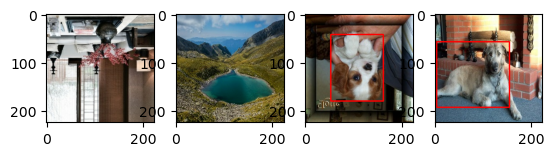

In [90]:
fig, ax = plt.subplots(1, 4)
for idx in range(4):
    image = batch[0][idx]
    bbox = batch[1][1][idx]
    cv2.rectangle(image, 
        tuple(np.multiply(bbox[:2], [224,224]).astype(int)),
        tuple(np.multiply(bbox[2:], [224,224]).astype(int)), 
        (255,0,0),
        2
    )
    ax[idx].imshow(image)

# 7. Build the detection model

In [91]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [92]:
def build_model():
    input_layer = Input(shape=(224, 224, 3))
    vgg16 = VGG16(include_top=False)(input_layer)
    
    # classification model
    cl1 = GlobalMaxPooling2D()(vgg16)
    cl2 = Dense(2048, activation='relu')(cl1)
    cl3 = Dense(1, activation='sigmoid')(cl2)
    
    # bbox model 
    bbox1 = GlobalMaxPooling2D()(vgg16)
    bbox2 = Dense(2048, activation='relu')(bbox1)
    bbox3 = Dense(4, activation='sigmoid')(bbox2)
                
    return Model(inputs=input_layer, outputs=[cl3, bbox3])    

In [93]:
def bbox_loc_loss(true_bbox, pred_bbox):
    # calculate bbox top-point localization loss
    bbox_loc_loss = tf.reduce_sum(tf.square(true_bbox[:,:2] - pred_bbox[:,:2]))
    
    # calculate bbox width and height loss
    true_height = true_bbox[:,3] - true_bbox[:,1]
    pred_height = pred_bbox[:,3] - pred_bbox[:,1]
    
    true_width = true_bbox[:,2] - true_bbox[:,0]
    pred_width = true_bbox[:,2] - true_bbox[:,0]
    
    bbox_size_loss = tf.reduce_sum(tf.square(true_height - pred_height) 
                                   + tf.square(true_width - pred_width))
    #return sum of above losses
    return bbox_loc_loss + bbox_size_loss

In [94]:
dog_detector = build_model()
loc_loss = bbox_loc_loss
class_loss = BinaryCrossentropy()
decay = (1.0 / 0.75 - 1) / len(train_set)
optimizer = Adam(learning_rate=0.0001, weight_decay=decay)

In [99]:
def train_step(X, y):
    with tf.GradientTape() as tape:
        classes, bboxes = dog_detector(X, training=True)
        classes_loss = class_loss(y[0], classes)
        bboxes_loss = loc_loss(tf.cast(y[1], tf.float32), bboxes)
        total_loss = bboxes_loss + 0.5 * classes_loss
        grad = tape.gradient(total_loss, dog_detector.trainable_variables)
    optimizer.apply_gradients(zip(grad, dog_detector.trainable_variables))

In [100]:
X, y = train_set.as_numpy_iterator().next()
train_step(X, y)